In [30]:
#labels : cat - dog
from skimage import color , exposure ,io , transform
import pathlib
import xml.etree.ElementTree as ET
from skimage.filters import gaussian
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
def read_voc_xml(xmlfile: str) -> dict:
    """read the Pascal VOC XML and return (filename, object name, bounding box)
    where bounding box is a vector of (xmin, ymin, xmax, ymax). The pixel
    coordinates are 1-based.
    """
    root = ET.parse(xmlfile).getroot()
    boxes = {"filename": root.find("filename").text,
             "objects": []
            }
    for box in root.iter('object'):
        bb = box.find('bndbox')
        obj = {
            "name": box.find('name').text,
            "xmin": int(bb.find("xmin").text),
            "ymin": int(bb.find("ymin").text),
            "xmax": int(bb.find("xmax").text),
            "ymax": int(bb.find("ymax").text),
        }
        boxes["objects"].append(obj)
 
    return boxes

base_path = pathlib.Path("E:/FCAI/ML/oxford-iiit-pet")
images_src = base_path / "images" 
annotation_src = base_path / "annotations" / "xmls"
features=[]
labels=[]
for xmlfile in annotation_src.glob("*.xml"):
    #read image from xml file
    ann = read_voc_xml(str(xmlfile))
    img = io.imread(str(images_src / ann["filename"]))
    bbox = ann["objects"][0]  
    # Append the label to the labels list
    labels.append(bbox["name"])
    #pre processing
    grayscale_image = color.rgb2gray(img) if len(img.shape) == 3 else img
    face_image = grayscale_image[bbox["ymin"] : bbox["ymax"], bbox["xmin"] : bbox["xmax"]]
    resized_image = transform.resize(face_image,(294 , 288))
    enhanced_image = exposure.equalize_adapthist(resized_image) #enhance contrast for better quality and for lighting regions
    gaussian_image = gaussian(enhanced_image, sigma=1) #guassian blur to filter noise
    #feature extraction
    hog_descriptor, hog_image = hog(image= gaussian_image, orientations= 8, pixels_per_cell=(8,8), cells_per_block=(1,1), visualize=True, block_norm='L2', feature_vector=True ,channel_axis=None)
    #display 
    '''
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 5))#for better hog image display
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('original image')
    axes[1].imshow(gaussian_image, cmap='gray')
    axes[1].set_title('pre processing image')
    axes[2].imshow(hog_image, cmap='gray')
    axes[2].set_title('HOG image')
    plt.show() 
    '''
    # Append the descriptor to the features list
    features.append(hog_descriptor) #hog_descriptor is numpy array

In [31]:
features_array = np.array(features)
#standardlization
features_array_standard  = StandardScaler().fit_transform(features_array)
#converting label names into numeric labels
numeric_labels = LabelEncoder().fit_transform(np.array(labels))
#split data
X_train, X_test, y_train, y_test = train_test_split(features_array_standard, numeric_labels, test_size=0.2, random_state=42, shuffle=True)
print("total numer of images: ", len(numeric_labels))
print(np.unique(numeric_labels))


total numer of images:  3686
[0 1]


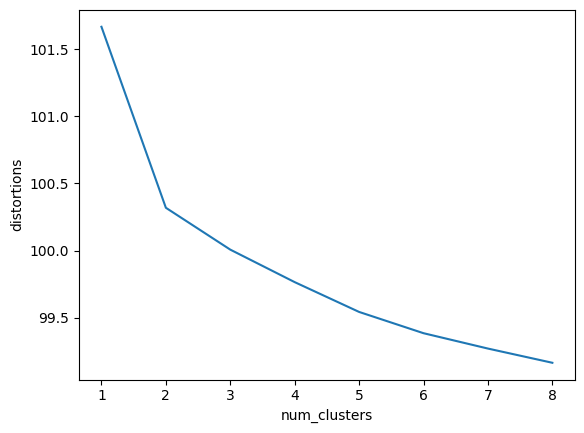

In [104]:
from scipy.cluster.vq import kmeans
import pandas as pd
import seaborn as sns
distortions = []
num_clusters = range(1, 9)
for i in num_clusters:
    cluster_centers, distortion = kmeans(X_train, i)
    distortions.append(distortion)
elbow_plot = pd.DataFrame({'num_clusters': num_clusters, 'distortions': distortions})
sns.lineplot(x='num_clusters', y='distortions', data=elbow_plot)
plt.xticks(num_clusters)
plt.show()

Train : 
Accuracy : 0.764246947082768


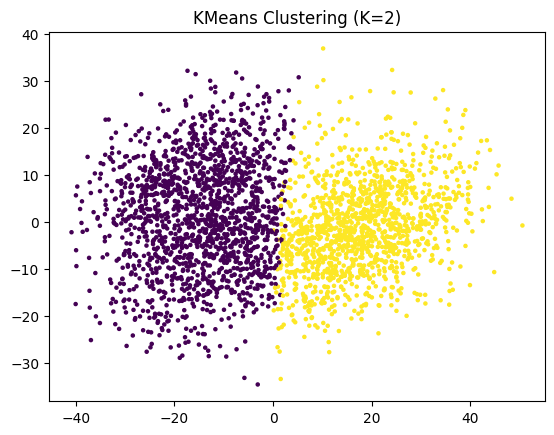

In [98]:
from sklearn.metrics import accuracy_score
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=1000,  tol=1e-04, random_state=48)
cluster_labels = kmeans.fit_predict(X_train)
print('Train : \nAccuracy : {}'.format(accuracy_score(cluster_labels,y_train)))
X_pca = PCA(n_components=2).fit_transform(X_train)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', marker='o', s=5)
plt.title(f'KMeans Clustering (K={2})')
plt.show()

Test : 
Accuracy : 0.7764227642276422


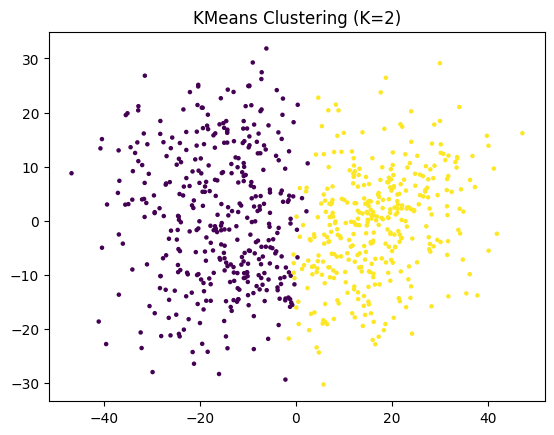

In [101]:
cluster_labels = kmeans.predict(X_test)
print('Test : \nAccuracy : {}'.format(accuracy_score(cluster_labels,y_test)))
X_pca = PCA(n_components=2).fit_transform(X_test)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', marker='o', s=5)
plt.title(f'KMeans Clustering (K={2})')
plt.show()